# Compare downstream of fine-tuned model vs direct transfer of BrainLM on development dataset

The development dataset and the prediction workflow is adopted from MAIN educational workshop on Nilearn.

This dataset is an easy target as there's a known bias: the coverage of the brain scan betwenn kids and adults are different in the cerebellum.
When using an atlas that covers the cerebellum to extract features, the classification task should easily overfit.

Since BrainLM uses an atlas that covers cerebellum, this is a good dataset to test if the features got through direct transfer is anything useful.

## Methods

The BrainLM model used: 650M and 111M.

Data preperation: giga-connectome, robust scaler normalisation.
Fine tune behaviour of data from the normalisation workflow shipped with BrainLM performs badly (R^2=0.0), hence it's not included in this comparison.

Prediction pipeline:
- Standard scalar on the feature
- PCA (5 components) on the standardised features
- Stratified 4 fold cross valiation
- Binary prediction with SVM (C=1, class_weight='balanced')


## Results
<!-- 
|Feature	| Time series | Functional connectivity | CLS token - attention head	| CLS token - embedding	| CLS token - attention head	| CLS token - embedding |CLS token - attention head	| CLS token - embedding	| CLS token - attention head	| CLS token - embedding |
|----|----|----|----|----|----|----|----|----|----|----|
| Model	| N/A | N/A | 650M	| 650M	| 650M	| 650M | 111M	| 111M	| 111M	| 111M |
| Fine-tune?	| N/A | N/A | N	| N	| Y	| Y | N	| N	| Y	| Y |
|Adult F1 score	| 0.4 |	0.85 |	0.36 |	0.53 |	0.33 |	0.67 | 0.33 | 0.56 | 0.34 | 0.54|
|Child F1 score	| 0.81 |	0.96 |	0.61 |	0.83 |	0.48 |	0.89 | 0.20 | 0.84 | 0.24 | 0.84|
|Overall accuracy |	0.71 |	0.94 |	0.52 |	0.75 |	0.41 |	0.84 | 0.27 | 0.77 | 0.29 | 0.76| -->

## Conclusions

- Features from BraimLM under perfrom comparing to functional connectivity, but better than  straight time series
- 650 M performs better than 111 M
- The CLS token from attension heads are all performing bad

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from datasets import load_from_disk
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

## Loading data

When creating baseline with the preprocessed recording.

For this task, functional connectivity is know to be the feature that can easily over fit.

For the baseline I will use functional connectivity and time series of the raw data.


In [2]:
# load data
features_direct = load_from_disk("../outputs/brainlm.vitmae_650M.direct_transfer.gigaconnectome")

ts_flatten = [np.array(example).reshape(3, 424, 160)[0].T.flatten() for example in features_direct['padded_recording']]

correlation_baseline = ConnectivityMeasure(
    kind="correlation", vectorize=True, discard_diagonal=True
)
ts = [np.array(example).reshape(3, 424, 160)[0].T for example in features_direct['padded_recording']]
fc_baseline = correlation_baseline.fit_transform(ts)

In [3]:
def pca_svc(C, x, y, title):
    """
    Extract the top 5 principal components and use a SVM to predict categorical
    label, 3 fold CV.
    """
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=5)), 
        ('svc', SVC(C=C, class_weight='balanced'))
    ])
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
    scores = cross_val_score(pipe, x, y, cv=cv)
    y_pred = cross_val_predict(pipe, x, y, cv=cv)

    overall_acc = accuracy_score(y_pred=y_pred, y_true=y)
    overall_cr = classification_report(y_pred=y_pred, y_true=y)
    overall_cm = confusion_matrix(y_pred=y_pred, y_true=y)
    print('Overall Accuracy:', overall_acc)

    # thresh = overall_cm.max() / 2
    # cmdf = pd.DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
    # plt.figure(figsize=(5, 4))
    # plt.title(title)
    # sns.heatmap(cmdf, cmap='copper', annot=cmdf, vmax=thresh, fmt="d")
    # plt.xlabel('Predicted')
    # plt.ylabel('Observed')
    return overall_cr

In [4]:
def plot_pca(feature, feature_name):
    """Plot PCA of the given feature."""
    ss = StandardScaler().fit(feature)
    feature = ss.transform(feature)
    pca = PCA(n_components=100)
    pca.fit(feature)
    feat_pca = pca.transform(feature)
    # plot pc as heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(feat_pca, cmap='viridis', cbar=True)
    plt.title(f'PCA of {feature_name}')
    plt.xlabel('Principal Components')
    plt.ylabel('Samples')
    plt.show()

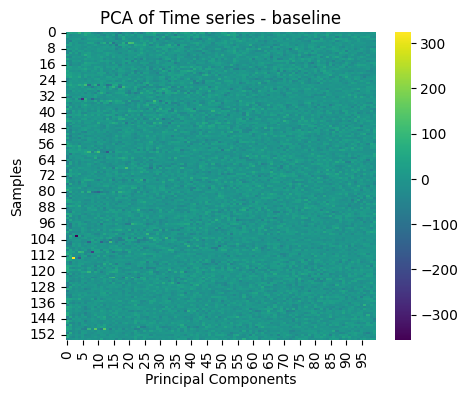

Overall Accuracy: 0.632258064516129


'              precision    recall  f1-score   support\n\n       adult       0.29      0.48      0.36        33\n       child       0.83      0.67      0.74       122\n\n    accuracy                           0.63       155\n   macro avg       0.56      0.58      0.55       155\nweighted avg       0.71      0.63      0.66       155\n'

In [5]:
plot_pca(ts_flatten, "Time series - baseline")

pca_svc(C=1, x=ts_flatten, y=np.array(features_direct['Child_Adult']), title="Time series - baseline")

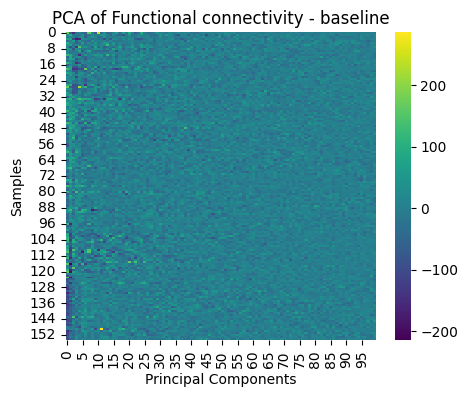

Overall Accuracy: 0.9225806451612903


'              precision    recall  f1-score   support\n\n       adult       0.82      0.82      0.82        33\n       child       0.95      0.95      0.95       122\n\n    accuracy                           0.92       155\n   macro avg       0.88      0.88      0.88       155\nweighted avg       0.92      0.92      0.92       155\n'

In [6]:
plot_pca(fc_baseline, "Functional connectivity - baseline")
pca_svc(C=1, x=fc_baseline, y=np.array(features_direct['Child_Adult']), title="Functional connectivity - baseline")

## Direct transfer

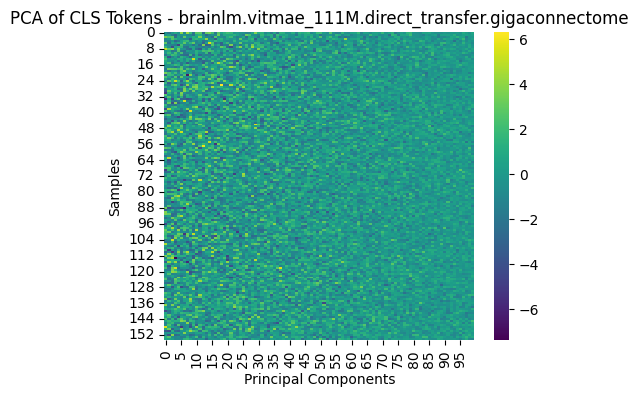

Overall Accuracy: 0.3741935483870968


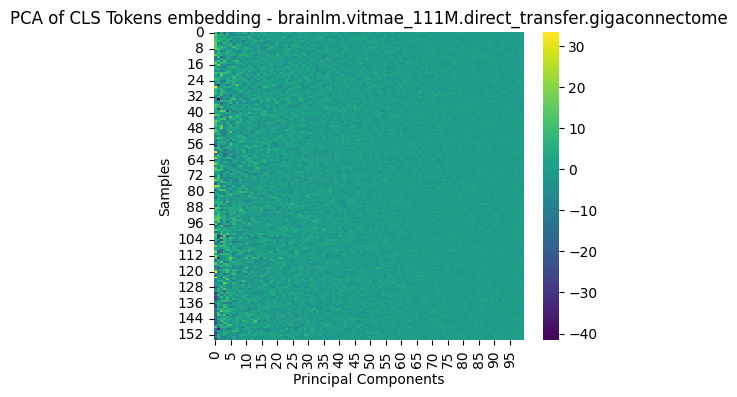

Overall Accuracy: 0.7354838709677419


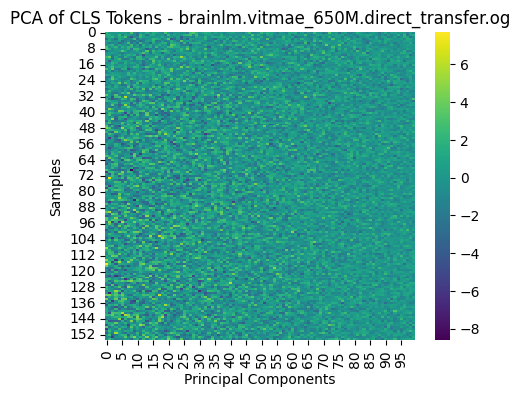

Overall Accuracy: 0.7548387096774194


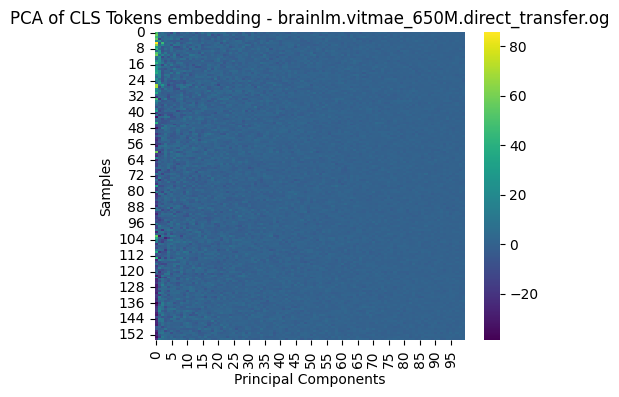

Overall Accuracy: 0.8258064516129032


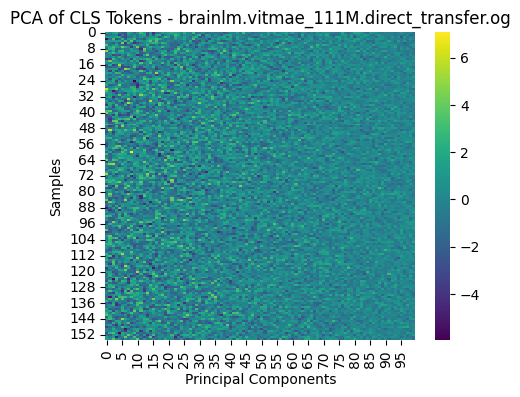

Overall Accuracy: 0.567741935483871


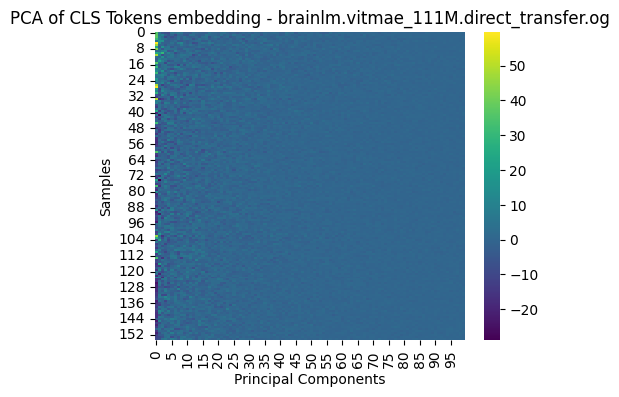

Overall Accuracy: 0.6774193548387096


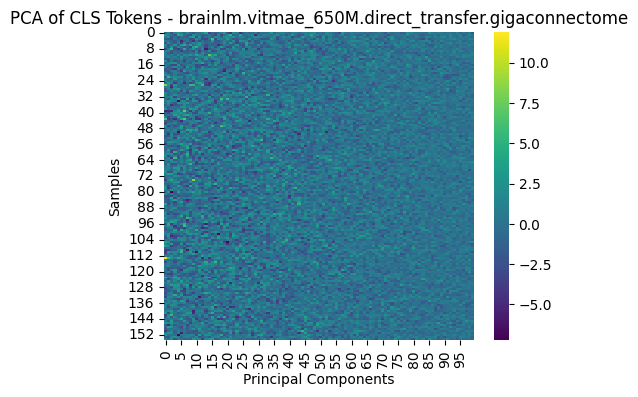

Overall Accuracy: 0.5741935483870968


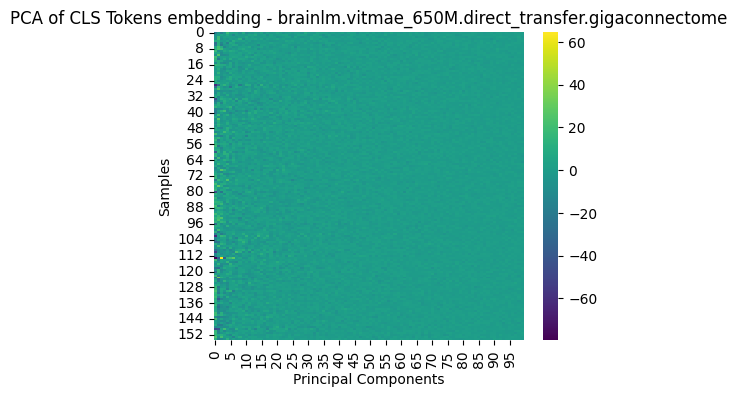

Overall Accuracy: 0.7935483870967742


In [7]:
for p in Path("../outputs/").glob("*direct*"):
    features = load_from_disk(p)
    plot_pca(np.array(features['cls_token']).squeeze(), f"CLS Tokens - {p.name.replace('.arrow', '')}")
    pca_svc(C=1, x=np.array(features['cls_token']).squeeze(), y=np.array(features['Child_Adult']), title=f"CLS Tokens - {p.name.replace('.arrow', '')}")
    plot_pca(np.array(features['cls_embedding']).squeeze(), f"CLS Tokens embedding - {p.name.replace('.arrow', '')}")
    pca_svc(C=1, x=np.array(features['cls_embedding']).squeeze(), y=np.array(features['Child_Adult']), title=f"CLS Tokens embedding - {p.name.replace('.arrow', '')}")

## Fine tuned

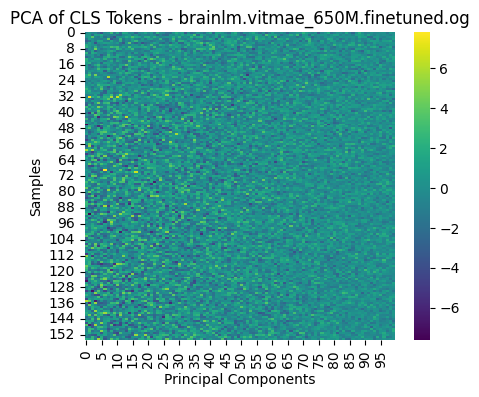

Overall Accuracy: 0.7741935483870968


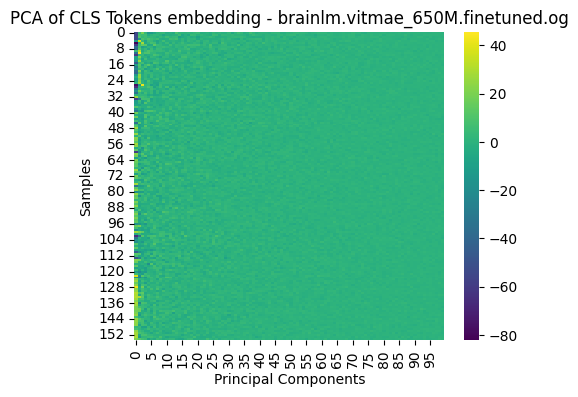

Overall Accuracy: 0.8129032258064516


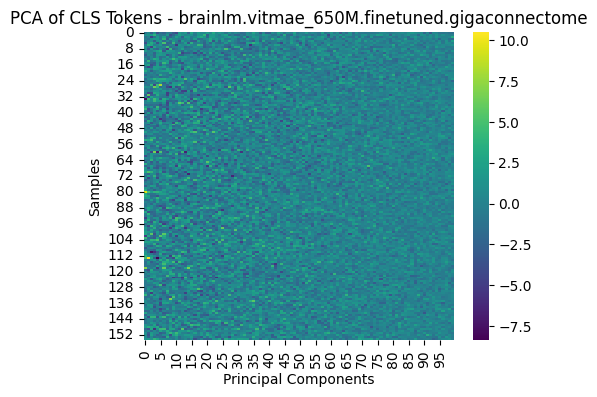

Overall Accuracy: 0.3096774193548387


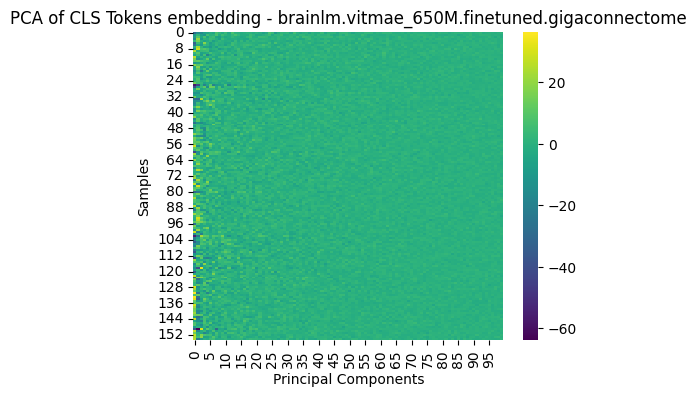

Overall Accuracy: 0.7935483870967742


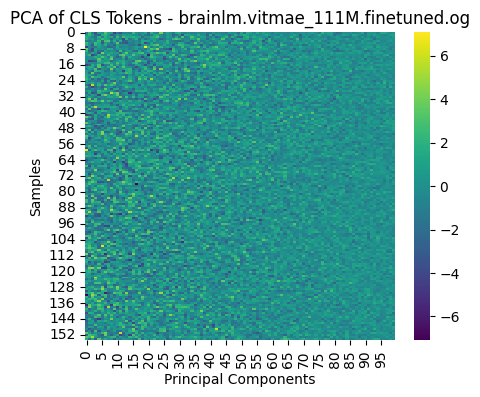

Overall Accuracy: 0.5548387096774193


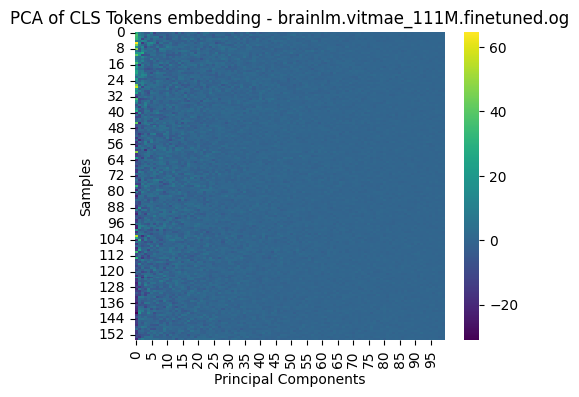

Overall Accuracy: 0.6967741935483871


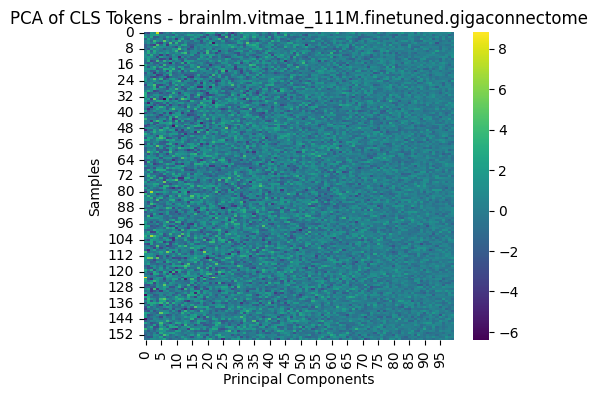

Overall Accuracy: 0.5870967741935483


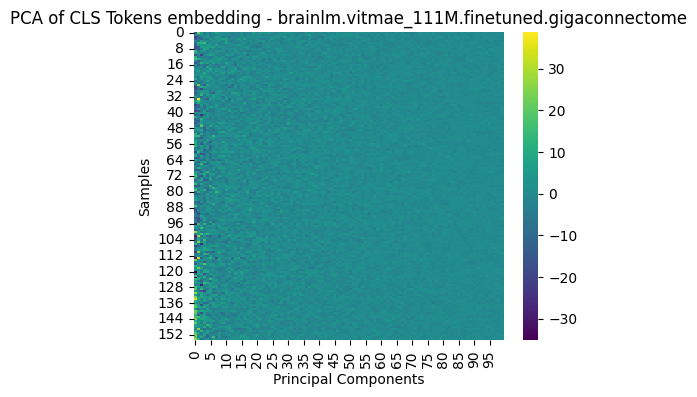

Overall Accuracy: 0.7806451612903226


In [12]:
for p in Path("../outputs/").glob("*finetune*"):
    features = load_from_disk(p)
    plot_pca(np.array(features['cls_token']).squeeze(), f"CLS Tokens - {p.name.replace('.arrow', '')}")
    pca_svc(C=1, x=np.array(features['cls_token']).squeeze(), y=np.array(features['Child_Adult']), title=f"CLS Tokens - {p.name.replace('.arrow', '')}")
    plot_pca(np.array(features['cls_embedding']).squeeze(), f"CLS Tokens embedding - {p.name.replace('.arrow', '')}")
    pca_svc(C=1, x=np.array(features['cls_embedding']).squeeze(), y=np.array(features['Child_Adult']), title=f"CLS Tokens embedding - {p.name.replace('.arrow', '')}")